In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_sig = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
  
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

Processing...
Done!


In [4]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE #+ KLD

In [7]:
num_epochs = 10
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch, train_loss))

Epoch : 0 , Minibatch : 0 Loss = 54992.3516
Epoch : 0 , Minibatch : 100 Loss = 2150799.4199
Epoch : 0 , Minibatch : 200 Loss = 1343763.4492
Epoch : 0 , Minibatch : 300 Loss = 1105921.6484
Epoch : 0 , Minibatch : 400 Loss = 988346.0996
Epoch : 0 , Minibatch : 500 Loss = 913474.1694
Epoch 0 : Loss = (7425012.0947) 
Epoch : 1 , Minibatch : 0 Loss = 8634.3633
Epoch : 1 , Minibatch : 100 Loss = 843335.2866
Epoch : 1 , Minibatch : 200 Loss = 823388.9956
Epoch : 1 , Minibatch : 300 Loss = 805700.9858
Epoch : 1 , Minibatch : 400 Loss = 799820.9624
Epoch : 1 , Minibatch : 500 Loss = 787130.7197
Epoch 1 : Loss = (4832993.3521) 
Epoch : 2 , Minibatch : 0 Loss = 7802.7759
Epoch : 2 , Minibatch : 100 Loss = 766282.5215
Epoch : 2 , Minibatch : 200 Loss = 762513.3379
Epoch : 2 , Minibatch : 300 Loss = 751979.7437
Epoch : 2 , Minibatch : 400 Loss = 747787.3550
Epoch : 2 , Minibatch : 500 Loss = 741135.1240
Epoch 2 : Loss = (4505421.2319) 
Epoch : 3 , Minibatch : 0 Loss = 7223.6831
Epoch : 3 , Minibatc

(784,)
torch.Size([784])


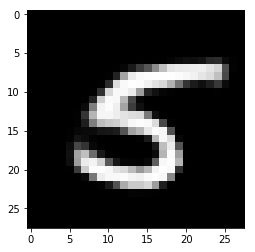

In [8]:
print(model(images)[0].data[0].numpy().shape)
image1 = images[8]
print(image1.shape)
plt.imshow(model(images)[0].data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

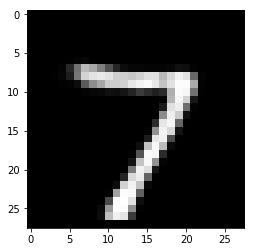

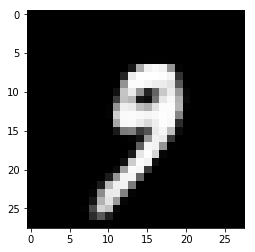

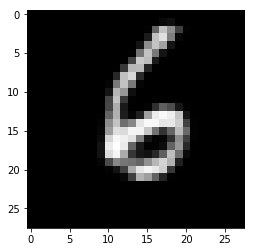

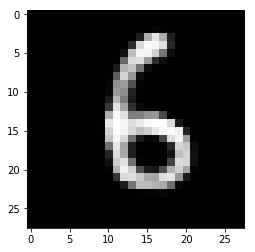

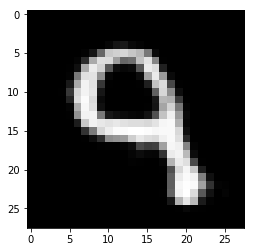

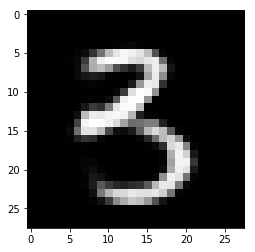

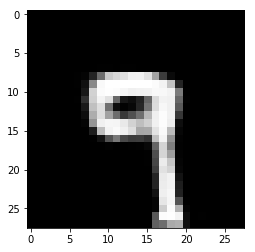

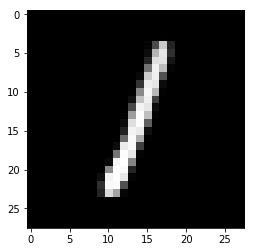

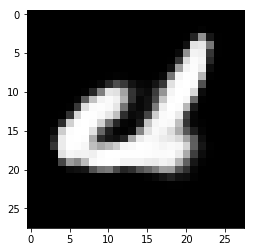

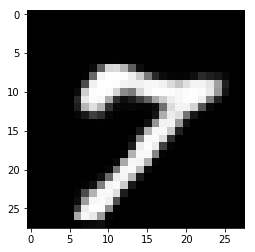

In [9]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.show(block=True)

In [10]:
image2 = images[1]
print(image2.shape)

torch.Size([784])


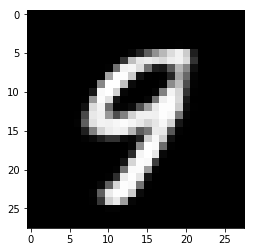

In [11]:
plt.imshow(model(images)[0].data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

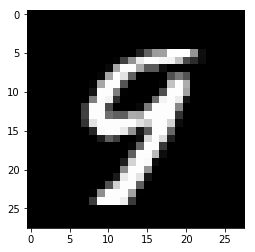

In [12]:
plt.imshow(images[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

In [13]:
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

In [14]:
with torch.no_grad():
    recon_images1 = []
    recon_images2 = []
    for ctr in range(0, 100, 5):
        eps_val = torch.full_like(mu1, fill_value = ctr * 0.01 )
        z_val1 = eps_val.mul(std1).add_(mu1)
        z_val2 = eps_val.mul(std2).add_(mu2)
        recon_image1 = model.decode(z_val1)
        recon_image2 = model.decode(z_val2)
        recon_images1.append(recon_image1)
        recon_images2.append(recon_image2)

In [15]:
print(recon_images1[0] - recon_images1[1])

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

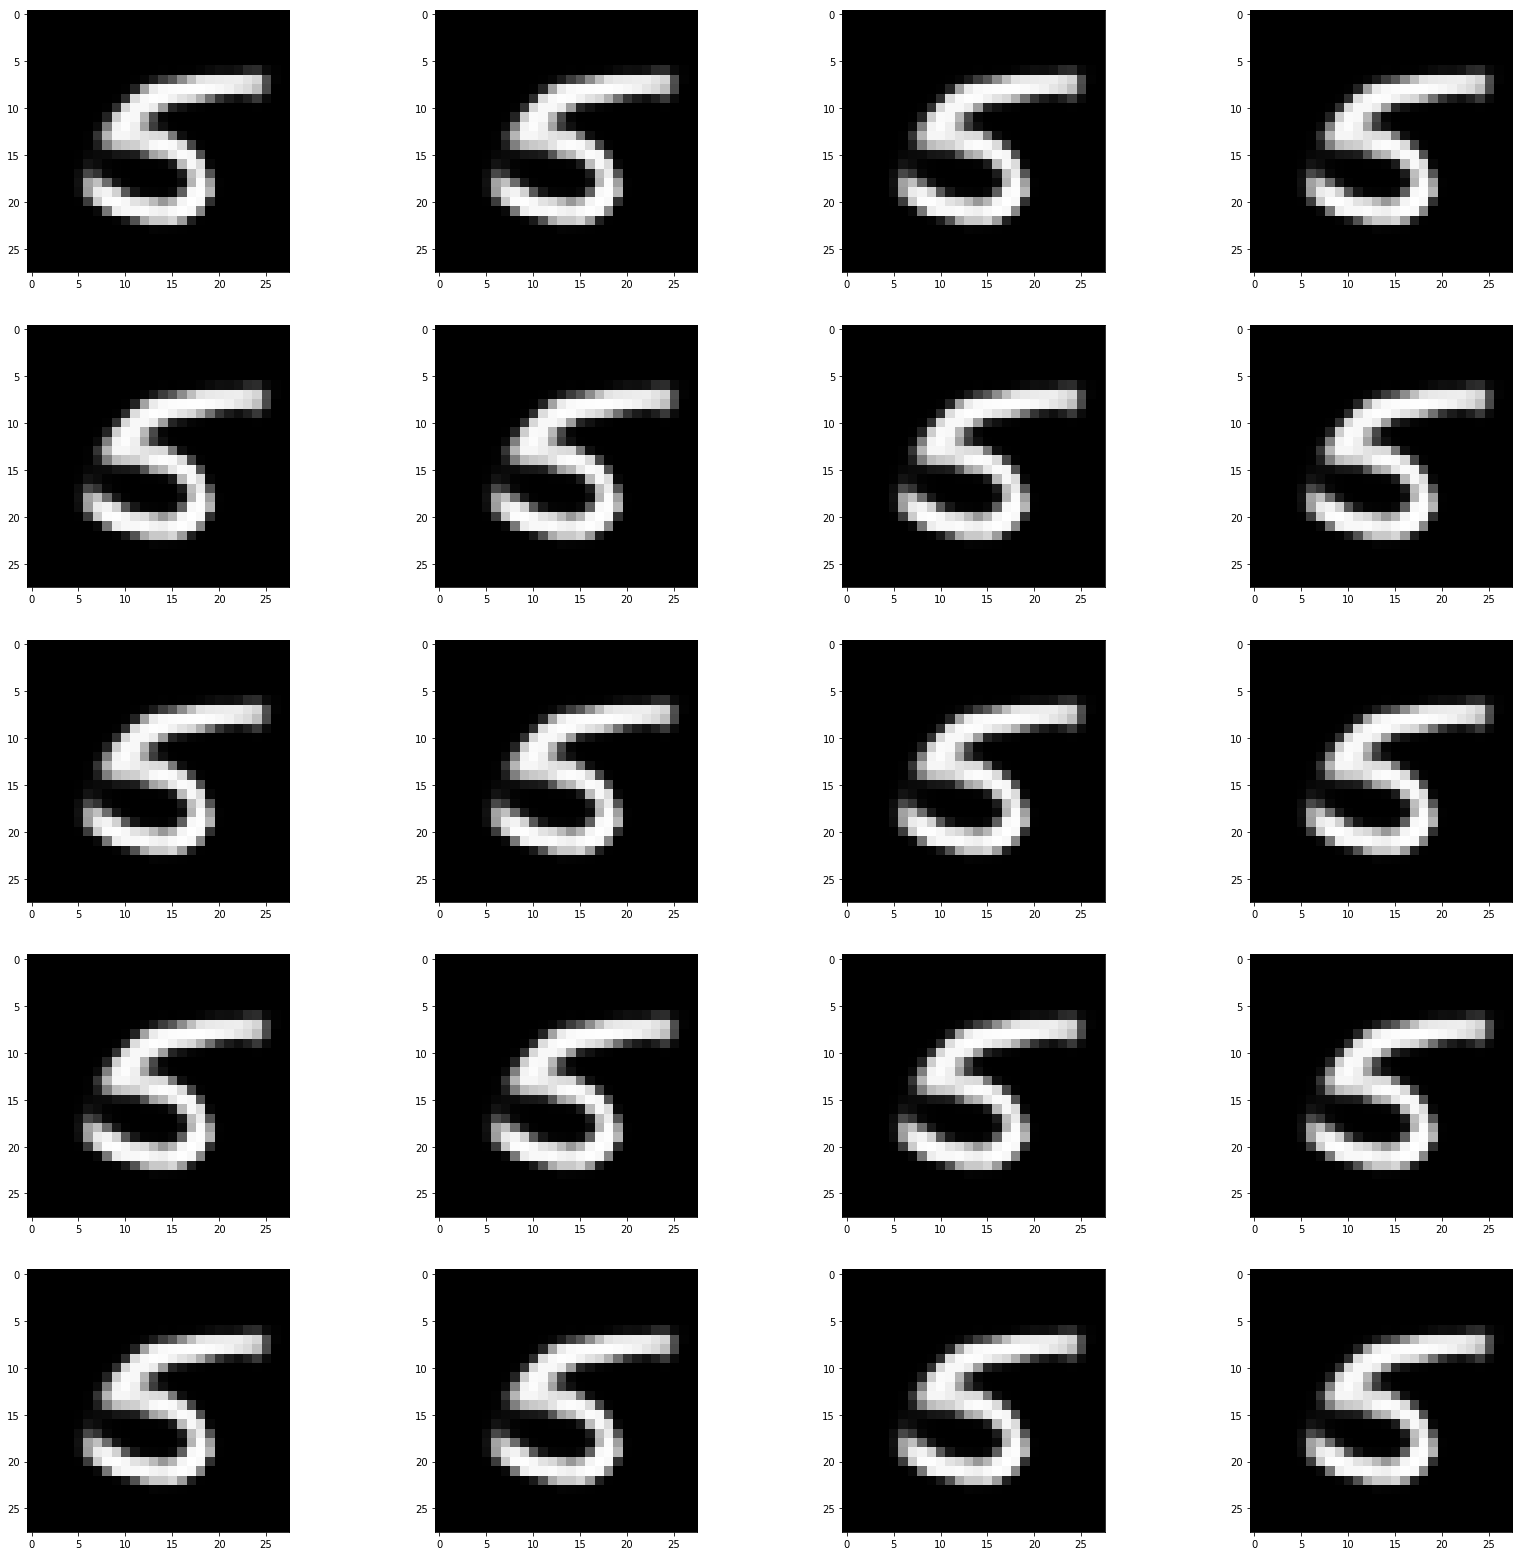

In [23]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

In [17]:
with torch.no_grad():
    recon_images1 = []
    recon_images2 = []
    eps_val = torch.randn_like(mu1)
    for ctr in range(0, 100, 5):
        eps_val[7] = ctr * 0.05 * std1[7] + mu1[7]
        z_val1 = eps_val.mul(std1).add_(mu1)
        z_val2 = eps_val.mul(std2).add_(mu2)
        recon_image1 = model.decode(z_val1)
        recon_image2 = model.decode(z_val2)
        recon_images1.append(recon_image1)
        recon_images2.append(recon_image2)

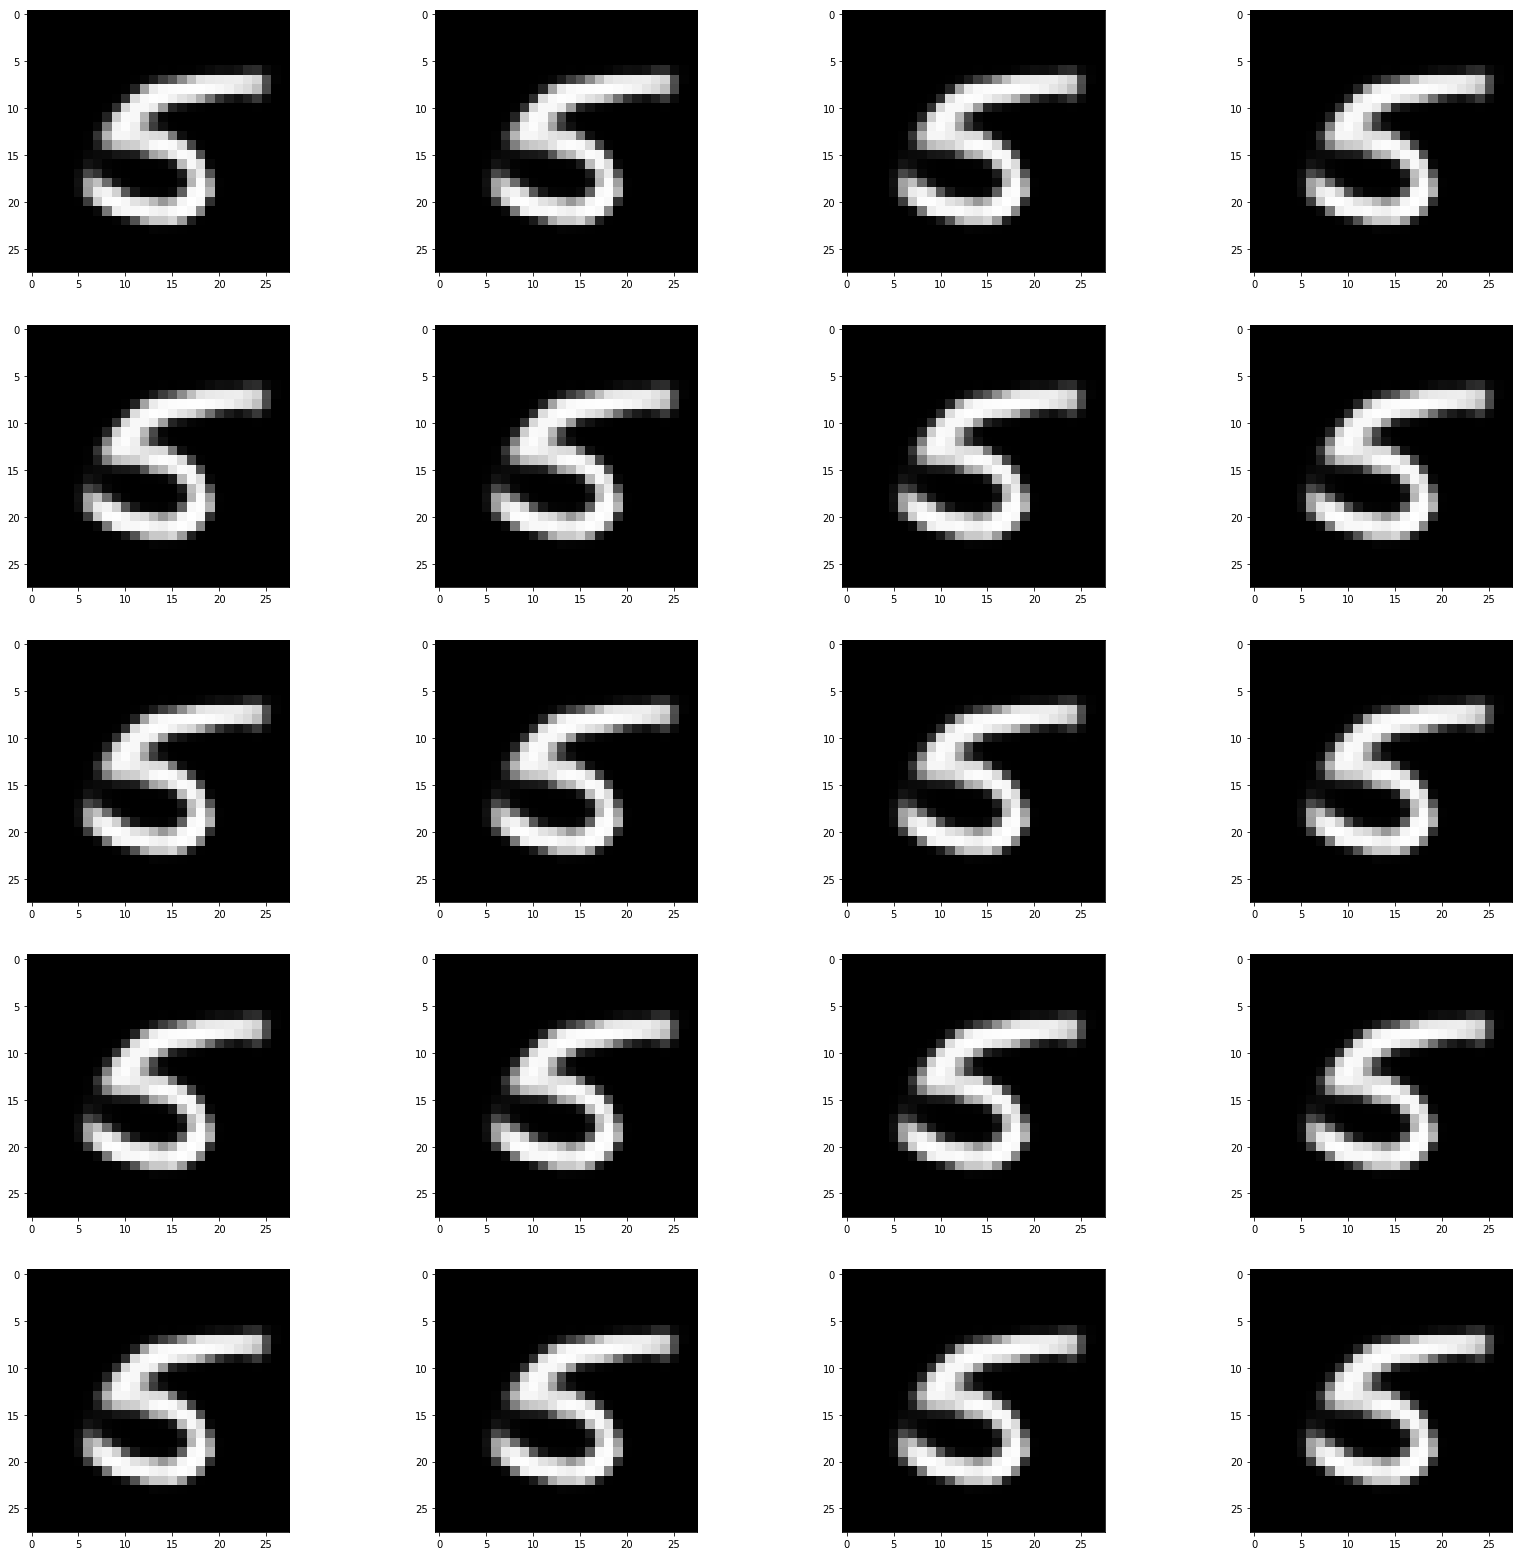

In [22]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

In [19]:
eps_any = torch.randn_like(mu1)
z1 = eps_any.mul(std1).add_(mu1)
z2 = eps_any.mul(std2).add_(mu2)
all_recons = []
for i in range(20):
    z_bet = z1 + torch.full_like(mu1, fill_value = 0.05*i).mul(z2 - z1)
    recon_image = model.decode(z_bet)
    all_recons.append(recon_image)

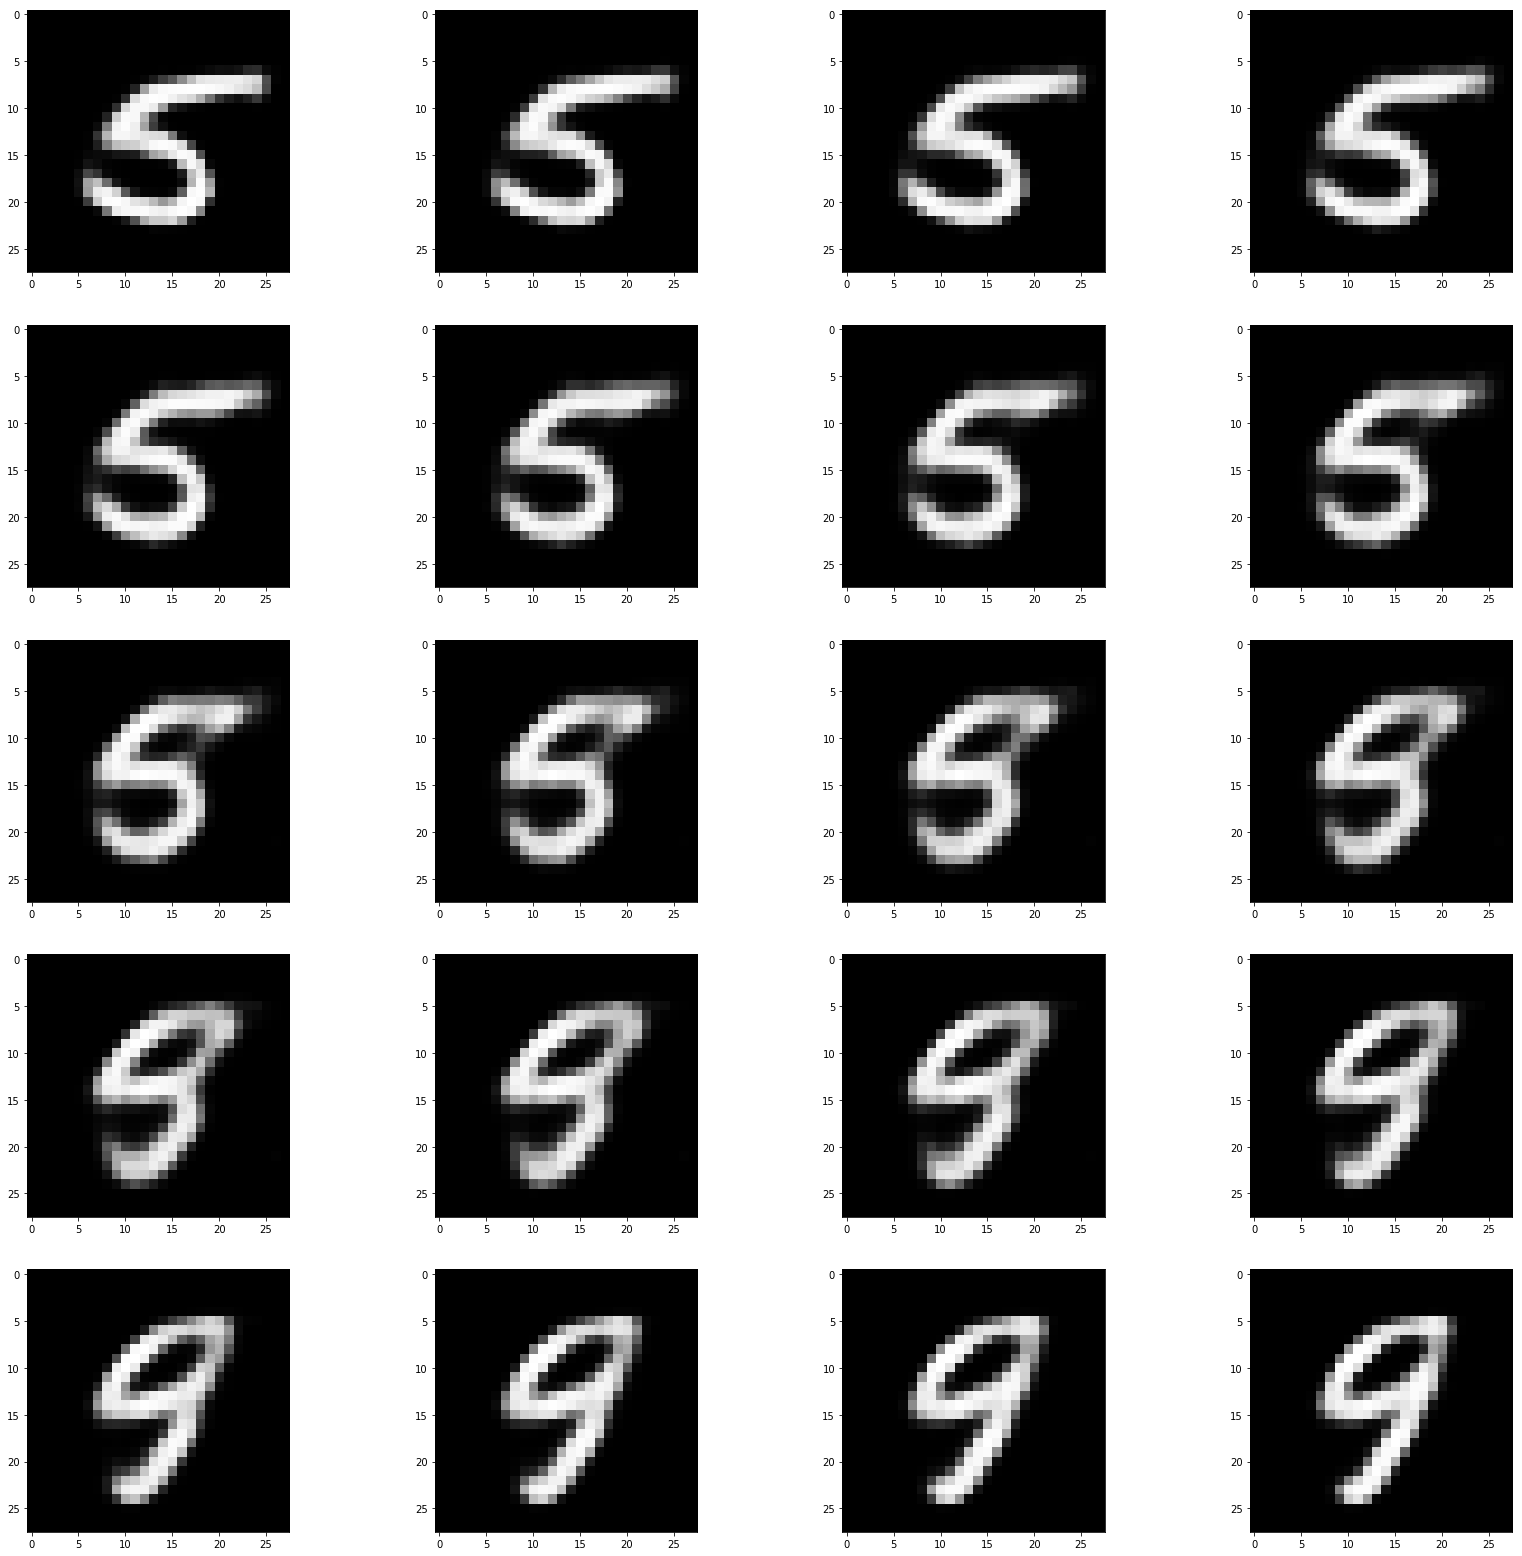

In [21]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = all_recons[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()